Copyright **`(c)`** 2021 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see 'LICENCE.md' for details.

In [1]:
import logging
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from matplotlib import cm

logging.basicConfig(format='[%(asctime)s] %(levelname)s: %(message)s', datefmt='%H:%M:%S', level=logging.INFO)

In [2]:
def rastrigin(x, A=10):
    """NumPy Rastrigin test function"""
    if x.ndim == 1:
        return -np.sum(A - A * np.cos(2*np.pi*x) + x**2)
    else:
        return -np.sum(A - A * np.cos(2*np.pi*x) + x**2, axis=1)

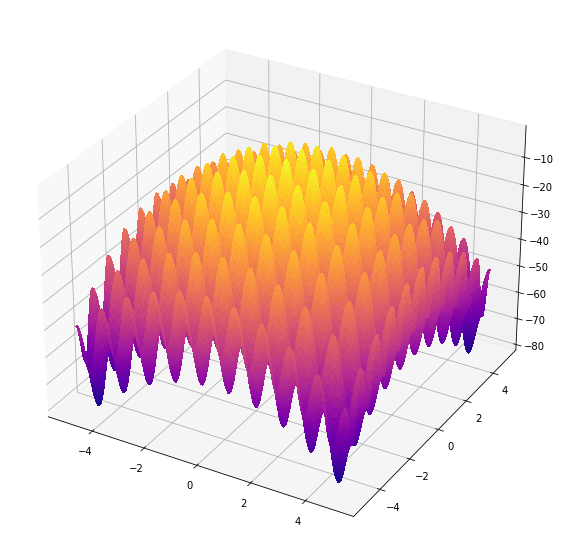

In [3]:
N_POINTS = 200
r = np.linspace(-5, 5, N_POINTS)

# yeuch, that's quite terrible...
x = np.array(np.meshgrid(r, r)).T.reshape(-1, 2)
z = rastrigin(x).reshape(N_POINTS, N_POINTS)
plt.figure(figsize=(10, 10)) 
ax = plt.axes(projection='3d')
ax.plot_surface(*np.meshgrid(r, r), z, rstride=1, cstride=1, cmap=cm.plasma, linewidth=0, antialiased=False)    
None

In [4]:
np.random.seed(42)
N_DIM = 4

## Vanilla (1+λ)-ES

  0%|          | 0/50000 [00:00<?, ?it/s]

[17:19:54] INFO: Best solution: -30.843473087556177


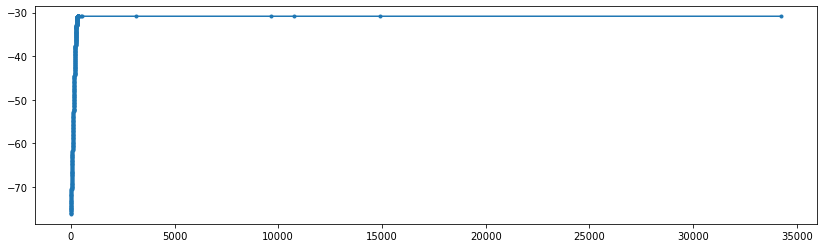

In [5]:
λ = 20
σ = .001

solution = np.random.random(N_DIM) * 5.12 * 2 - 5.12
history = list()
best_so_far = np.copy(solution)

for n in tqdm(range(1_000_000 // λ)):
    # offspring <- select λ random points mutating the current solution
    offspring = np.random.normal(loc=0, scale=σ, size=(λ, N_DIM)) + solution
    # evaluarte and select best
    evals = rastrigin(offspring)
    solution = offspring[np.argmax(evals)]
    if rastrigin(best_so_far) < rastrigin(solution):
        best_so_far = np.copy(solution)
        history.append((n, rastrigin(solution)))

logging.info(f"Best solution: {rastrigin(best_so_far)}")

history = np.array(history)
plt.figure(figsize=(14, 4)) 
plt.plot(history[:,0], history[:,1], marker='.')

## Adaptive (1+λ)-ES

  0%|          | 0/50000 [00:00<?, ?it/s]

[17:19:59] INFO: Best solution: -32.83352837088732 (current σ=0.120)


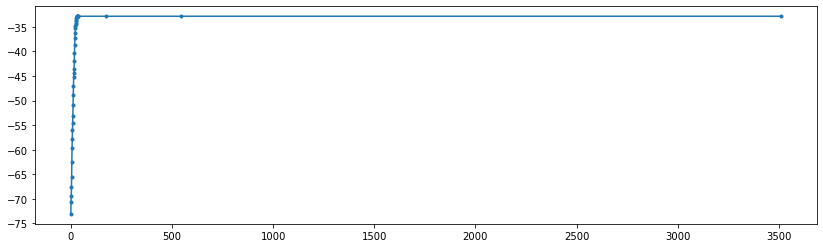

In [6]:

λ = 20
σ = .01

solution = np.random.random(N_DIM) * 5.12 * 2 - 5.12
history = list()
best_so_far = np.copy(solution)

stats = [0, 0]
for step in tqdm(range(1_000_000 // λ)):
    samples = np.random.normal(loc=0, scale=σ, size=(λ, N_DIM)) + solution
    evals = rastrigin(samples)
    stats[0] += λ
    stats[1] += sum(evals > rastrigin(solution))
    solution = samples[np.argmax(evals)]

    if rastrigin(best_so_far) < rastrigin(solution):
        best_so_far = np.copy(solution)
        history.append((step, rastrigin(solution)))

    if (step+1) % 200 == 0:
        if stats[0]/stats[1] < 1/5:
            σ /= 1.01
        elif stats[0]/stats[1] > 1/5:
            σ *= 1.01
        steps = [0, 0]

logging.info(f"Best solution: {rastrigin(best_so_far)} (current σ={σ:0.3f})")

history = np.array(history)
plt.figure(figsize=(14, 4)) 
plt.plot(history[:,0], history[:,1], marker='.')

## Adaptive (μ+λ)-ES

  0%|          | 0/20000 [00:00<?, ?it/s]

[17:20:00] INFO: Best solution: -1.9899181448700767 (with σ=0.000)


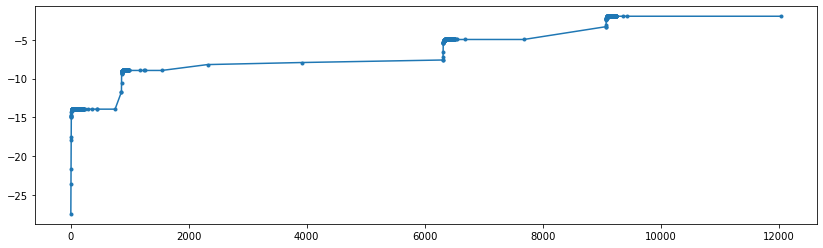

In [7]:
μ = 5
λ = 50
σ = 1

population = np.random.random((μ, N_DIM + 1))
population[:,:-1] = population[:,:-1] * 5.12 * 2 - 5.12
population[:,-1] *= σ

best_so_far = None
history = list()
for step in tqdm(range(1_000_000 // λ)):
    # offspring <- select λ random points from the population of μ
    offspring = population[np.random.randint(0, μ, size=(λ,))]
    # mutate all σ (last column) and replace negative values with a small number
    offspring[:,-1] = np.random.normal(loc=offspring[:,-1], scale=.2)
    offspring[offspring[:,-1] < 0, -1] = 1e-5
    # mutate all v (all columns but the last), using the σ in the last column
    offspring[:,0:-1] = np.random.normal(loc=offspring[:,0:-1], scale=offspring[:,-1].reshape(-1, 1))
    # add an extra column with the evaluation and sort
    offspring = np.concatenate([offspring, rastrigin(offspring[:,0:-1]).reshape(-1, 1)], axis=1)
    offspring = offspring[offspring[:, -1].argsort()]
    # save best (just for the plot)
    if best_so_far is None or best_so_far < offspring[-1,-1]:
        best_so_far = offspring[-1,-1]
        history.append((step, best_so_far))
    # select the μ with max fitness and discard fitness
    population = np.copy(offspring[-μ:,:-1])

final = np.concatenate([population, rastrigin(population[:,0:-1]).reshape(-1, 1)], axis=1)
best_individual = final[final[:, -1].argsort()][-1]
logging.info(f"Best solution: {best_individual[-1]} (with σ={best_individual[-2]:0.3f})")

history = np.array(history)
plt.figure(figsize=(14, 4)) 
plt.plot(history[:,0], history[:,1], marker='.')